In [1]:
%matplotlib inline

from kmedoids import fasterpam
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from persim import plot_diagrams
from ripser import ripser
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC
from tqdm import tqdm

# from atlas_covariant import *
from atlas_general import *
from grass_utils import *
from manifold_utils import quad_covector_to_covector_and_inner, \
                            quad_fit_full, \
                            matrix_to_quad_vector_matrix
from yao_utils_otra import *

Computing brute matrix...


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 237.32it/s]

Done


In [2]:
data_dir = "data/klein"

X = np.load(data_dir+"/klein_uniform_10000.npy")
# X = np.load(data_dir+"/klein_uniform_1000.npy")

n_pts, d = X.shape

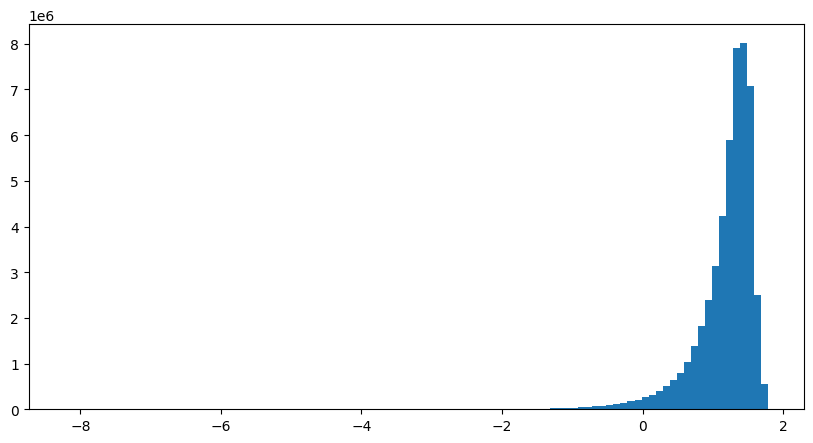

In [3]:
dist_mat_raw = euclidean_distances(X, X)

triu_inds = np.triu_indices(n_pts, 1)
dist_mat_flat = dist_mat_raw[triu_inds]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

# ax.hist(dist_mat_flat, bins=100)
ax.hist(np.log(dist_mat_flat), bins=100)

plt.show()

In [4]:
# Get "fine mesh", local distance graph
# delta = 0.1
# eps = 0.1
n_neigh = 10

G = nx.Graph()
for j in tqdm(range(n_pts)):
    X_j = X[j, :].reshape(1, 9)
    G.add_node(j)
    dist_vec = euclidean_distances(X_j, X)[0, :]
    inds_otra = list(range(n_pts))
    inds_otra.sort(key=lambda x: dist_vec[x])
    for k in inds_otra[1:(n_neigh+1)]:
        dist = dist_vec[k]
        G.add_edge(j, k, weight=dist)
    # for k in range(j+1, n_pts):
    #     dist = dist_vec[k]
    #     if dist <= eps:
    #         G.add_edge(j, k, weight=dist)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [01:27<00:00, 113.67it/s]


In [5]:
try:
    dist_mat = np.load("dist_mat_experimental.npy")
except FileNotFoundError:
    dist_mat = np.zeros((n_pts, n_pts))
    
    for j in tqdm(range(n_pts)):
        dist_dict, _ = nx.single_source_dijkstra(G, j, weight="weight")
        for k in range(j+1, n_pts):
            dist = dist_dict[k]
            dist_mat[j, k] = dist
            dist_mat[k, j] = dist

    np.save("dist_mat_experimental.npy", dist_mat)

In [6]:
try:
    theta_list = np.load("thetas_experimental.npy")
    phi_list = np.load("phis_experimental.npy")
except FileNotFoundError:
    theta_list = []
    phi_list = []
    for j in tqdm(range(n_pts)):
        x = X[j, :]
        theta, phi = find_closest_theta_phi_brute(x)
        theta_list.append(theta)
        phi_list.append(phi)
    
    np.save("thetas_experimental.npy", theta_list)
    np.save("phis_experimental.npy", phi_list)

100%|████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 39.50it/s]


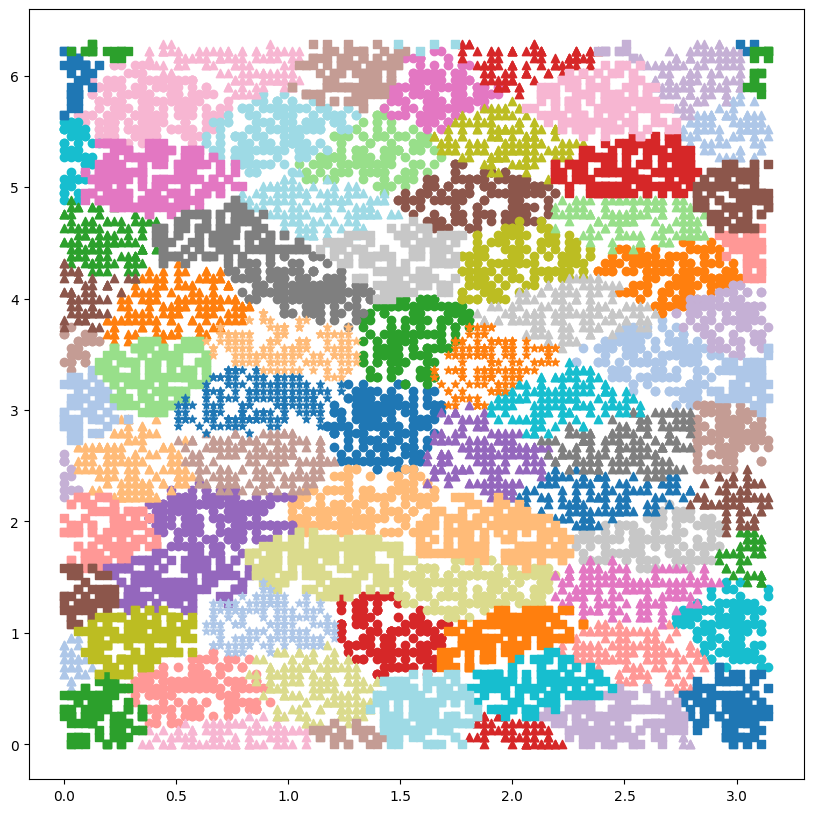

In [7]:
max_iter = int(1e8)
k = 64
pam_obj = fasterpam(dist_mat, k, max_iter=max_iter)

cmap_pre = plt.cm.tab20
n_colors = cmap_pre.N
# extract all colors from the .jet map
cmaplist = [cmap_pre(i) for i in range(cmap_pre.N)]
shaplist = ["o", "^", "s", "*"]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()

for label in tqdm(range(k)):
    color = cmaplist[label % n_colors]
    shape = shaplist[label // n_colors]
    
    inds_oi = [ind for ind, val in enumerate(pam_obj.labels) \
                                      if (val == label)]
    thetas_oi = [theta_list[ind] for ind in inds_oi]
    phis_oi = [phi_list[ind] for ind in inds_oi]

    ax.scatter(thetas_oi, phis_oi, color=color, marker=shape)

# for j in tqdm(range(n_pts)):
#     label = int(pam_obj.labels[j])
#     color = cmaplist[label % n_colors]
#     shape = shaplist[label // n_colors]

#     theta = theta_list[j]
#     phi = phi_list[j]
#     ax.scatter(theta, phi, color=color, marker=shape)

plt.show()

In [8]:
Y = matrix_to_quad_vector_matrix(X)

L_list = []
M_list = []
h_mat_list = []
x_0_list = []
X_par_list = []
t_mat_list = []

A_list = []
b_list = []
c_list = []

for label in range(k):
# for label in tqdm(range(k)):
    inds_oi = [ind for ind, val in enumerate(pam_obj.labels) \
                                      if (val == label)]
    labels_binary = [(val == label) for val in pam_obj.labels]
    svc_weights = [(np.inf if val else 1.0) for val in labels_binary]

    X_oi = X[inds_oi, :]
    Y_oi = Y[inds_oi, :]
    
    inds_no = [ind for ind in range(n_pts) if (ind not in inds_oi)]
    Y_no = Y[inds_no, :]
    
    svc = SVC(kernel="linear")
    svc.fit(Y, labels_binary, sample_weight=svc_weights)
    c_list.append(svc.coef0)
    b, A = quad_covector_to_covector_and_inner(svc.coef_.reshape(-1), 9)
    b_list.append(b)
    A_list.append(A)
    
    # Create local quadratic approximation
    quad_params = quad_fit_full(X_oi, 2)
    L = quad_params["L"]
    M = quad_params["M"]
    h_mat = quad_params["h_mat"]
    x_0 = quad_params["mean"]

    L_list.append(L)
    M_list.append(M)
    h_mat_list.append(h_mat)
    x_0_list.append(x_0)

In [9]:
atlas_gen = atlas_general(2, 9)

for x_0, L, M, h_mat, A, b, c in zip(x_0_list, 
                                    L_list, M_list,
                                    h_mat_list,
                                    A_list, b_list,
                                    c_list):
    atlas_gen.add_new_chart(x_0, L, M, h_mat, A, b, c)

LinAlgError: Singular matrix

In [ ]:
atlas_gen.save_atlas(".", "random_klein.atlas")